Plot time-mean layer interfaces at (i) 0°E over southern channel and (ii) zonally averaged over -40 and 70

In [1]:
import numpy as np
import xarray as xr
import cmocean as cmocean
import numpy.linalg as la
from scipy.io import netcdf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from xgcm import Grid
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib.colors import SymLogNorm, BoundaryNorm
from matplotlib.ticker import LogFormatter
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']

In [2]:
# Thickness and interfaces
root = '/scratch/mp6191/NW2_TracerBackscatter'

exp = '/p5_noBS_KHTR0_2'
p5_noBS = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')
p5_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p5_eta = xr.open_dataset(root + exp + '/MOM_IC.nc', decode_times = False).eta.isel(Time = -1).rename({'Interface' : 'zi', 'lath' : 'yh', 'lonh' : 'xh'})

exp = '/p5_SQGBS_KHTR0_2'
p5_SQGBS = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')

exp = '/p25_noBS_2'
p25_noBS = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')
p25_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p25_eta = xr.open_dataset(root + '/p25_SpinUp' + '/MOM_IC.nc', decode_times = False).eta.isel(Time = -1).rename({'Interface' : 'zi', 'lath' : 'yh', 'lonh' : 'xh'})

exp = '/p25_SQGBS_2'
p25_SQGBS = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')

exp = '/p03125_2'
p03125 = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')
p03125_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p03125_eta = xr.open_dataset('/scratch/mp6191/NW2_TracerBackscatter/p03125_IC/MOM_IC_4.nc', decode_times = False).eta.isel(Time = -1).rename({'Interface' : 'zi', 'lath' : 'yh', 'lonh' : 'xh'})

# Grid
p5_grid = Grid(p5_static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                    'Y': {'center': 'yh', 'outer': 'yq'}})

p25_grid = Grid(p25_static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                      'Y': {'center': 'yh', 'outer': 'yq'}})

p03125_grid = Grid(p03125_static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                            'Y': {'center': 'yh', 'outer': 'yq'}})

/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Ser

In [6]:
def get_colors_from_cmap(cmap_name, n_colors):
    cmap = cm.get_cmap(cmap_name)
    return [cmap(i / (n_colors - 1)) for i in range(n_colors)]

blues   = get_colors_from_cmap('Blues', 10)
reds = ['#f69a8b', '#b91a38']
greys = get_colors_from_cmap('Greys', 10)

colorlist_p5 = [blues[4], reds[0]]
colorlist_p25 = [blues[8], reds[1]]
colorlist_p03125 = [greys[3], greys[5], 'k']

/state/partition1/job-65564871/ipykernel_2802836/3569882092.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


In [21]:
def plot_isopycnal_section(unparameterized, backscatter, eta, static, ref, ref_eta, ref_static, xh, num_interface, coarsen_scale):
    grid = Grid(static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                  'Y': {'center': 'yh', 'outer': 'yq'}})
    ref_grid = Grid(ref_static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                          'Y': {'center': 'yh', 'outer': 'yq'}})
    
    # unparameterized
    h = unparameterized.sel(xh = xh, method = 'nearest').compute()
    e = (0 * eta).sel(xh = xh, method = 'nearest').fillna(0.).compute()
    D = static.depth_ocean.sel(xh = xh, method = 'nearest').compute()
    for i in range(e.zi.size):
        e[i, :] = -D + np.nansum(h[i : , :], axis = 0)
    e = e + 0 * eta
    e_yq_un = grid.interp(e, 'Y', boundary = 'fill').sel(xh = xh, method = 'nearest').fillna(0.)
    
    # backscatter
    h = backscatter.sel(xh = xh, method = 'nearest').compute()
    e = (0 * eta).sel(xh = xh, method = 'nearest').fillna(0.).compute()
    D = static.depth_ocean.sel(xh = xh, method = 'nearest').compute()
    for i in range(e.zi.size):
        e[i, :] = -D + np.nansum(h[i : , :], axis = 0)
    e = e + 0 * eta
    e_yq_bs = grid.interp(e, 'Y', boundary = 'fill').sel(xh = xh, method = 'nearest').fillna(0.)

    h = ref.coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().sel(xh = xh, method = 'nearest').compute()
    e = (0 * eta).sel(xh = xh, method = 'nearest').fillna(0.).compute()
    D = ref_static.depth_ocean.coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().sel(xh = xh, method = 'nearest').compute()
    for i in range(num_interface):
        e[i, :] = -D + np.nansum(h[i : , :], axis = 0)
    e = e + 0 * eta
    e_yq_ref = grid.interp(e, 'Y', boundary = 'fill').sel(xh = xh, method = 'nearest').fillna(0.)

    # Plot bathymetry as gray
    ax.set_facecolor('lightgray')
    ax.set_facecolor((0.92, 0.92, 0.92))
    ax.pcolormesh(e_yq_ref.yq, e_yq_ref, 0 * h, cmap = 'Greys')
    
    # plot
    for i in range(num_interface):
        
        if i == 0:
            ax.plot(e_yq_un.yq, e_yq_un.isel(zi = i), linewidth = 1, color = 'darkmagenta', label = 'unparameterized')
            ax.plot(e_yq_bs.yq, e_yq_bs.isel(zi = i), linewidth = 1, color = 'tomato', label = 'backscatter')
            ax.plot(e_yq_ref.yq, e_yq_ref.isel(zi = i), linewidth = 1, color = 'k', label = 'coarsened ref')
        else:
            ax.plot(e_yq_un.yq, e_yq_un.isel(zi = i), linewidth = 1, color = 'darkmagenta')
            ax.plot(e_yq_bs.yq, e_yq_bs.isel(zi = i), linewidth = 1, color = 'tomato')
            ax.plot(e_yq_ref.yq, e_yq_ref.isel(zi = i), linewidth = 1, color = 'k')

In [56]:
def plot_isopycnal_zm(unparameterized, backscatter, eta, static, ref, ref_eta, ref_static, xh, num_interface, coarsen_scale):
    grid = Grid(static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                  'Y': {'center': 'yh', 'outer': 'yq'}})
    ref_grid = Grid(ref_static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                          'Y': {'center': 'yh', 'outer': 'yq'}})
    
    # unparameterized
    h = unparameterized.load()
    e = (0 * eta).mean('xh').fillna(0.).load()
    D = static.depth_ocean.load()
    for i in range(num_interface):
        e[i, :] = (h.isel(zl = slice(i, None)).sum('zl', skipna = True) - D).mean('xh')
    e = e + 0 * eta
    e_yq_un = grid.interp(e, 'Y', boundary = 'fill').mean('xh')#.fillna(0.)
    
    # backscatter
    h = backscatter.load()
    e = (0 * eta).mean('xh').fillna(0.).load()
    D = static.depth_ocean.load()
    for i in range(num_interface):
        e[i, :] = (h.isel(zl = slice(i, None)).sum('zl', skipna = True) - D).mean('xh')
    e = e + 0 * eta
    e_yq_bs = grid.interp(e, 'Y', boundary = 'fill').mean('xh')#.fillna(0.)

    # ref
    h = ref.coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().load()
    e = (0 * eta).mean('xh').fillna(0.).load()
    #D = static.depth_ocean.load()
    D = ref_static.depth_ocean.coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().load()
    for i in range(num_interface):
        e[i, :] = (h.isel(zl = slice(i, None)).sum('zl', skipna = True) - D).mean('xh')
    e = e + 0 * eta
    e_yq_ref = grid.interp(e, 'Y', boundary = 'fill').mean('xh').fillna(0.)

    # Plot bathymetry as gray
    ax.set_facecolor('lightgray')
    ax.set_facecolor((0.92, 0.92, 0.92))
    ax.pcolormesh(e_yq_ref.yq, e_yq_ref, 0 * h.mean('xh'), cmap = 'Greys')
    
    # plot
    for i in range(num_interface - 1):
        
        if i == 0:
            ax.plot(e_yq_un.yq, e_yq_un.isel(zi = i), linewidth = 1, color = 'darkmagenta', label = 'unparameterized')
            ax.plot(e_yq_bs.yq, e_yq_bs.isel(zi = i), linewidth = 1, color = 'tomato', label = 'backscatter')
            ax.plot(e_yq_ref.yq, e_yq_ref.isel(zi = i), linewidth = 1, color = 'k', label = 'coarsened ref')
        elif i == num_interface - 2:
            ax.plot(e_yq_un.yq.sel(yq = slice(0, None)), e_yq_un.isel(zi = i).sel(yq = slice(0, None)), linewidth = 1, color = 'darkmagenta', label = 'unparameterized')
            ax.plot(e_yq_bs.yq.sel(yq = slice(0, None)), e_yq_bs.isel(zi = i).sel(yq = slice(0, None)), linewidth = 1, color = 'tomato', label = 'backscatter')
            ax.plot(e_yq_ref.yq.sel(yq = slice(0, None)), e_yq_ref.isel(zi = i).sel(yq = slice(0, None)), linewidth = 1, color = 'k', label = 'coarsened ref')
        else:
            ax.plot(e_yq_un.yq, e_yq_un.isel(zi = i), linewidth = 1, color = 'darkmagenta')
            ax.plot(e_yq_bs.yq, e_yq_bs.isel(zi = i), linewidth = 1, color = 'tomato')
            ax.plot(e_yq_ref.yq, e_yq_ref.isel(zi = i), linewidth = 1, color = 'k')

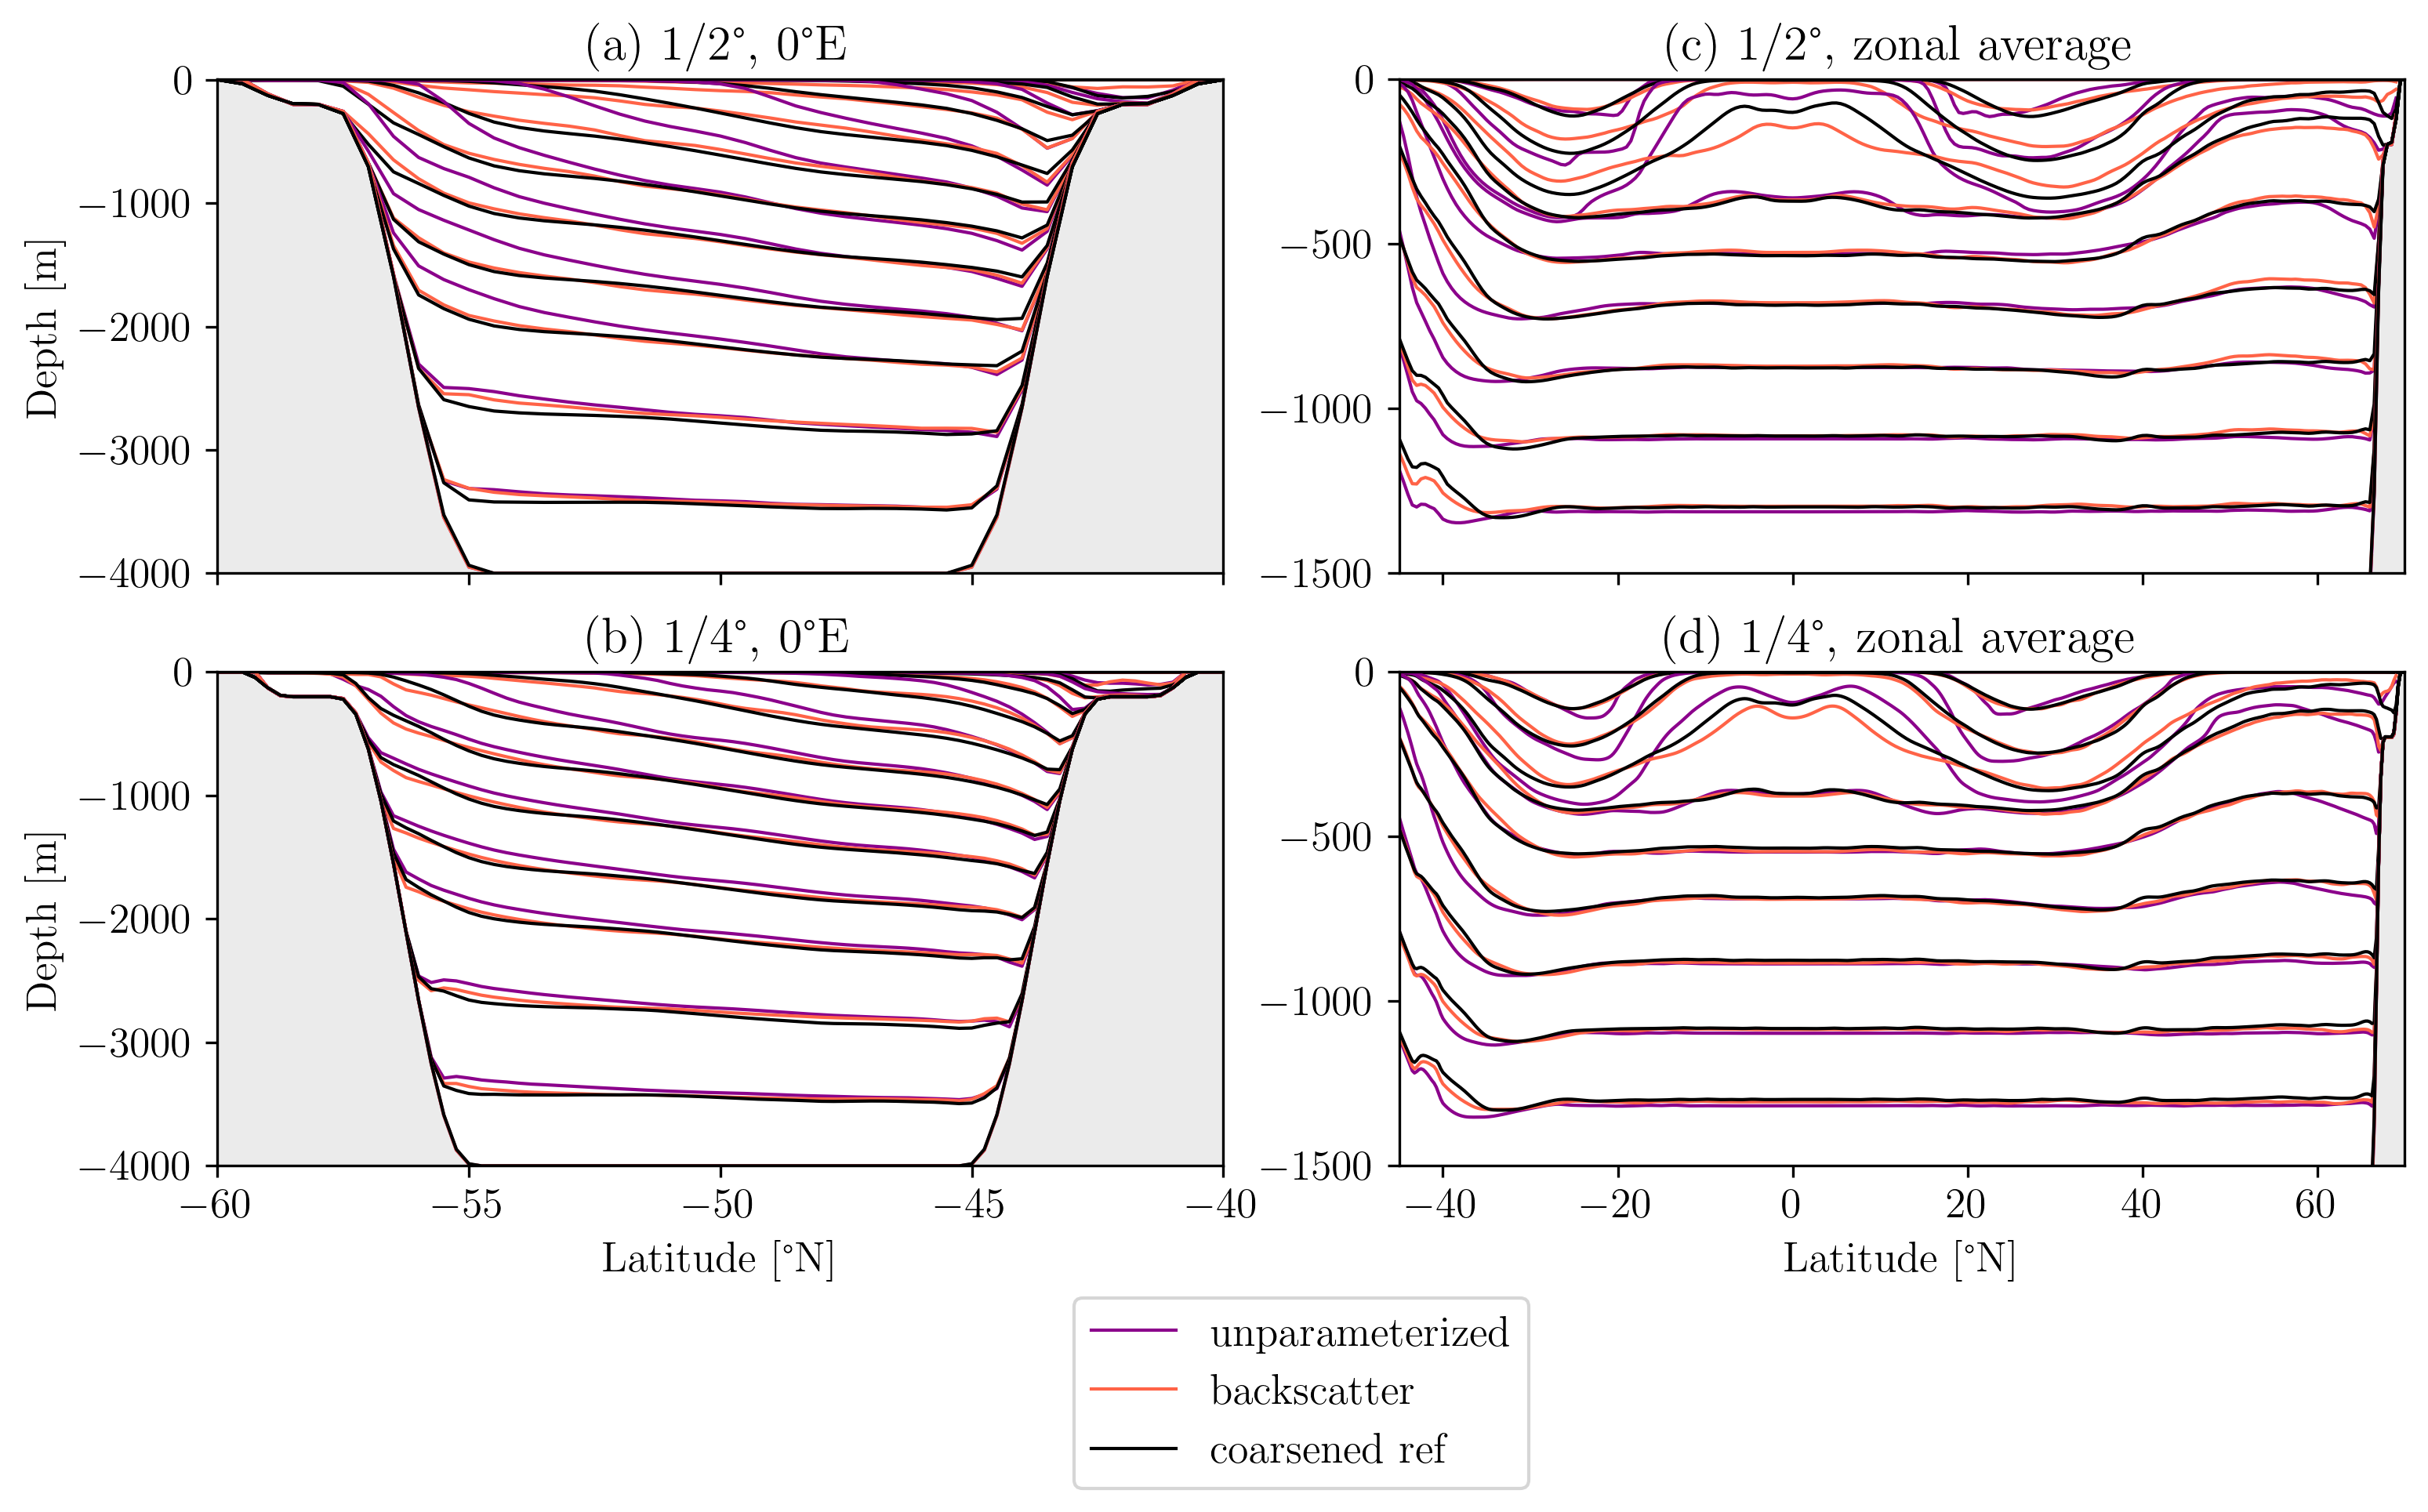

In [60]:
fig, axs = plt.subplots(figsize = (12, 6), nrows = 2, ncols = 2, dpi = 300, facecolor = 'w', edgecolor = 'k')
fontsize = 13

# (a) 1/2°, S.O.
ax = axs[0, 0]
xh = 0
num_interface = 16

#ax.set_facecolor((0.92, 0.92, 0.92))
ax.set_title(r'(a) 1/2°, 0°E', fontsize = fontsize + 2)
ax.set_xlabel('', fontsize = fontsize)
ax.set_ylabel('Depth [m]', fontsize = fontsize)
ax.tick_params(labelsize = fontsize)
ax.set_xticks(np.linspace(-60, -40, 5))    
ax.set_xlim([-60, -40])
ax.set_ylim([-4000, None])
plot_isopycnal_section(p5_noBS, p5_SQGBS, p5_eta, p5_static, p03125, p03125_eta, p03125_static, xh, num_interface, int(0.5 / 0.03125))
ax.tick_params(labelbottom = False)

# (b) 1/4°, S.O.
ax = axs[1, 0]
xh = 0
num_interface = 16

ax.set_title(r'(b) 1/4°, 0°E', fontsize = fontsize + 2)
ax.set_xlabel('Latitude [°N]', fontsize = fontsize)
ax.set_ylabel('Depth [m]', fontsize = fontsize)
ax.tick_params(labelsize = fontsize)
ax.set_xticks(np.linspace(-60, -40, 5))    
ax.set_xlim([-60, -40])
ax.set_ylim([-4000, 0])
plot_isopycnal_section(p25_noBS, p25_SQGBS, p25_eta, p25_static, p03125, p03125_eta, p03125_static, xh, num_interface, int(0.25 / 0.03125))
ax.legend(fontsize = fontsize, bbox_to_anchor = (1.325, -0.2))

# (c) 1/2°, zonal mean
ax = axs[0, 1]
num_interface = 12

ax.set_title(r'(c) 1/2°, zonal average', fontsize = fontsize + 2)
ax.set_xlabel('', fontsize = fontsize)
ax.set_ylabel('', fontsize = fontsize)
ax.tick_params(labelsize = fontsize)
ax.set_xticks(np.linspace(-40, 60, 6))   
ax.set_yticks(np.linspace(-1500, 0, 4)) 
ax.set_xlim([-45, 70])
ax.set_ylim([-1500, 0])
ax.tick_params(labelbottom = False)
plot_isopycnal_zm(p5_noBS, p5_SQGBS, p5_eta, p5_static, p03125, p03125_eta, p03125_static, xh, num_interface, int(0.5 / 0.03125))

# (d) 1/4°, zonal mean
ax = axs[1, 1]
num_interface = 12

ax.set_title(r'(d) 1/4°, zonal average', fontsize = fontsize + 2)
ax.set_xlabel('Latitude [°N]', fontsize = fontsize)
ax.set_ylabel('', fontsize = fontsize)
ax.tick_params(labelsize = fontsize)
ax.set_xticks(np.linspace(-40, 60, 6))   
ax.set_yticks(np.linspace(-1500, 0, 4)) 
ax.set_xlim([-45, 70])
ax.set_ylim([-1500, 0])
plot_isopycnal_zm(p25_noBS, p25_SQGBS, p25_eta, p25_static, p03125, p03125_eta, p03125_static, xh, num_interface, int(0.25 / 0.03125))

plt.subplots_adjust(wspace = 0.175, hspace = 0.2)

plt.savefig('Fig_isopycnals.pdf', bbox_inches = 'tight', dpi = 300)